# Misc Notebook. Visualization 

In this notebook, we visualize some of the content that we study throughout the development of EPGS. It includes visualizing the entire raw recording, representative of waveforms, result of signal trasnformation, etc. 

In [79]:
import numpy as np
import pandas as pd
import librosa
import pywt
import matplotlib.pyplot as plt
import seaborn as sns 

from utils import visualization, preprocessing
from utils.configs_utils import process_config
from dataset_utils import datagenerator, datahelper

from copy import deepcopy as dc
from easydict import EasyDict
import os 
%load_ext autoreload
%autoreload 2

[WinError 2] The system cannot find the file specified: './EPGS'
c:\Dung\EPG_project\EPGS
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


c:\Dung\.env\Lib\site-packages\IPython\core\magics\osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


# An entire EPG recording and 7 waveforms

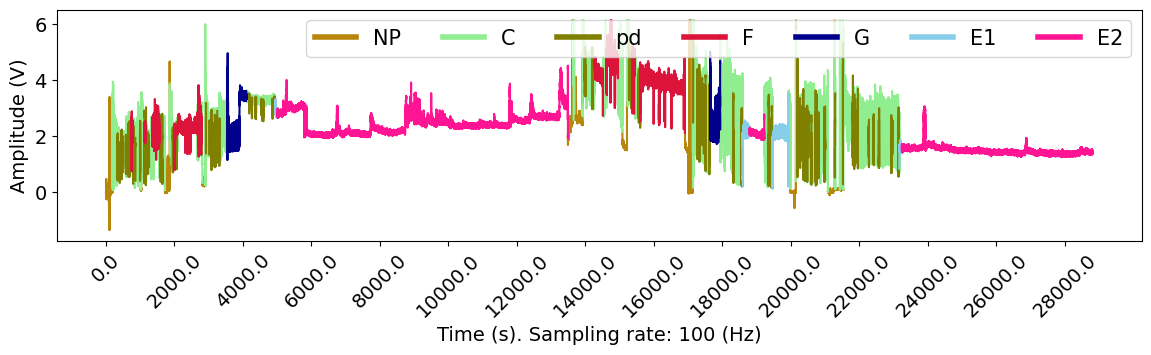

In [3]:
filename = '16zt_2022_10_04-ch5'
rec, ana = datahelper.read_signal(filename)

plt.rcParams.update({'font.size': 16})
c = visualization.c
plt.figure(figsize = (14,3))
visualization.visualize_signal(rec,ana)


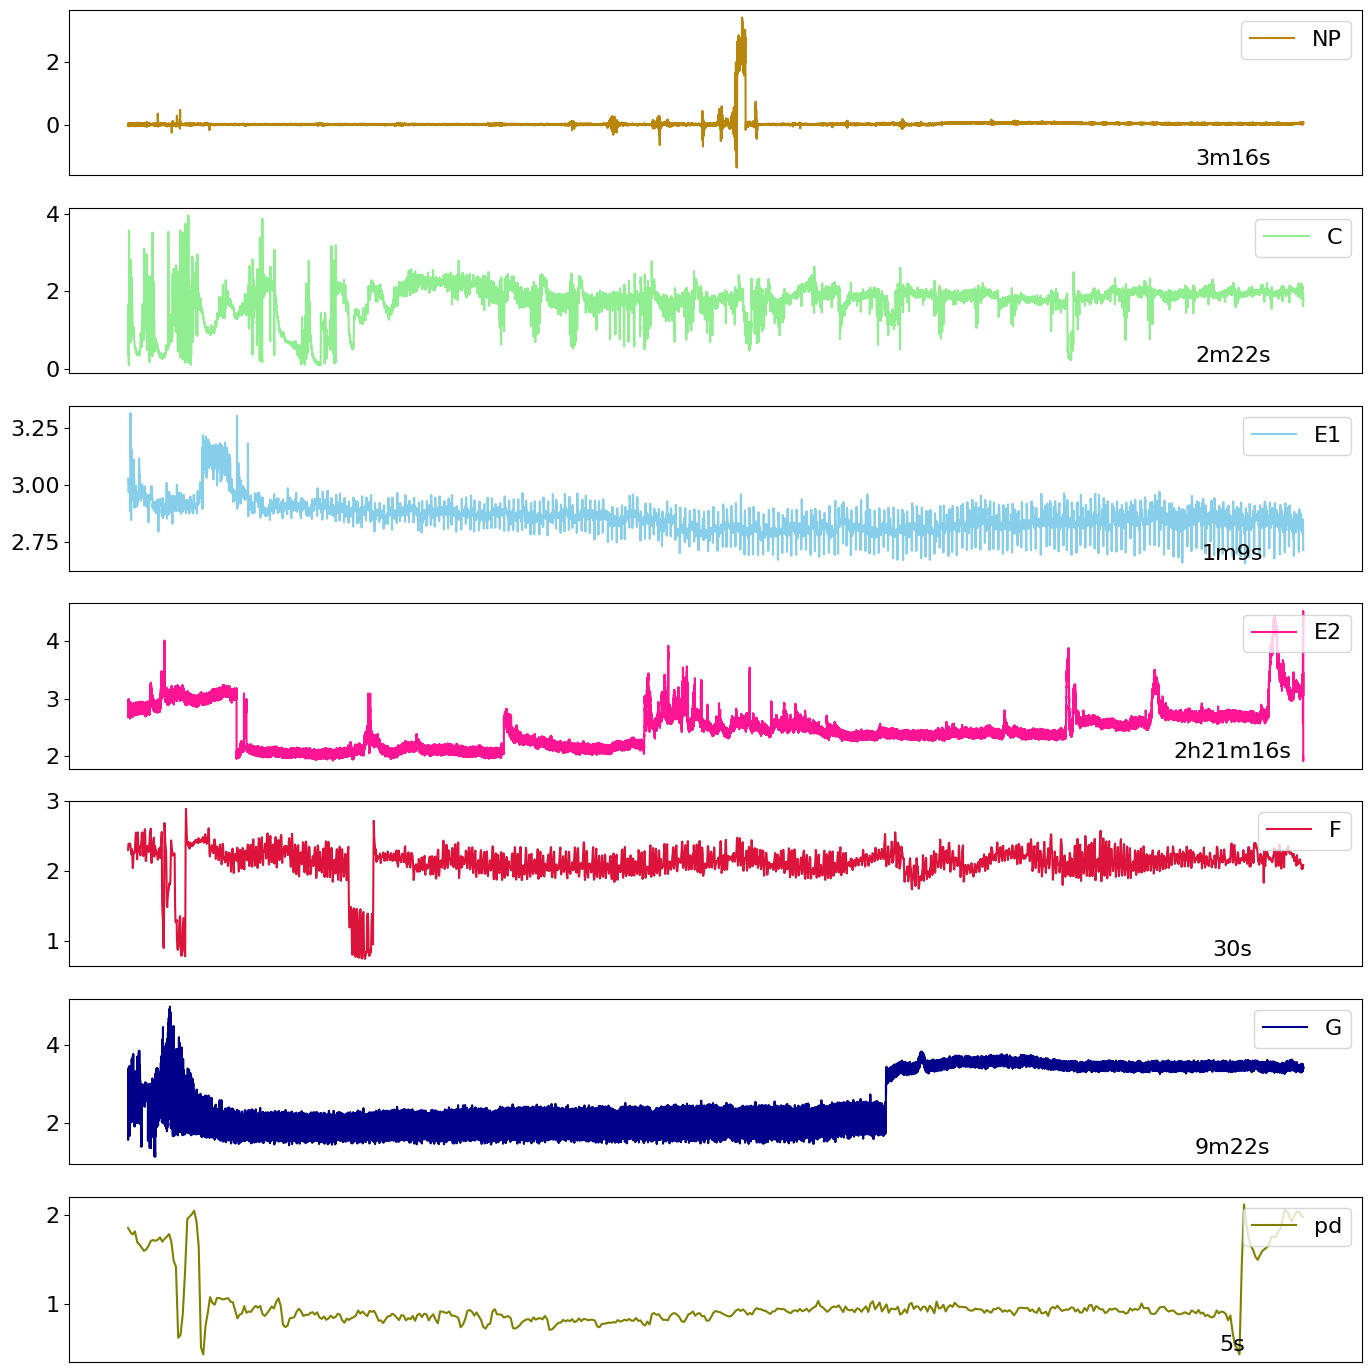

In [17]:
all_waveform_names = ['NP', 'C', 'E1', 'E2', 'F', 'G', 'pd']
wave_idx = datahelper.get_index(ana) # get list of (start, end) positions of waveforms

plt.rcParams.update({'font.size': 16})
f, ax = plt.subplots(7,1, figsize = (14,14))
for idx, waveform_name in enumerate(all_waveform_names):
    idx = idx
    start, end = wave_idx[waveform_name][0] # plot the first occurence of all waveforms
    start, end = int(start*100) , int(end*100) 
    x = np.arange(start, end)
    ax[idx].plot(x, rec[x], color = c[waveform_name], label = waveform_name)
    ax[idx].legend(loc = 'upper right')
    ax[idx].set_xticks([])
    duration = end-start
    if duration > 6000:
        duration = (end-start)//100
        minutes = duration // 60
        seconds = duration % 60
        if minutes > 60:
            hours = minutes // 60
            minutes = minutes % 60
             
            ax[idx].text(0.9, 0.1, f'{hours}h{minutes}m{seconds}s', horizontalalignment='center', verticalalignment='center', transform=ax[idx].transAxes)
        else:
            ax[idx].text(0.9, 0.1, f'{minutes}m{seconds}s', horizontalalignment='center', verticalalignment='center', transform=ax[idx].transAxes)
    else:
        ax[idx].text(0.9, 0.1, f'{(end-start)//100}s', horizontalalignment='center', verticalalignment='center', transform=ax[idx].transAxes)
plt.subplots_adjust(hspace=0)
plt.tight_layout()
plt.show()


# Signal processing 

## Fourier transform

In [31]:
filename = '16zt_2022_10_04-ch5'
rec, ana = datahelper.read_signal(filename)
rec

array([-0.011     , -0.009     ,  0.047     , ...,  1.46300006,
        1.46899998,  1.47399998])

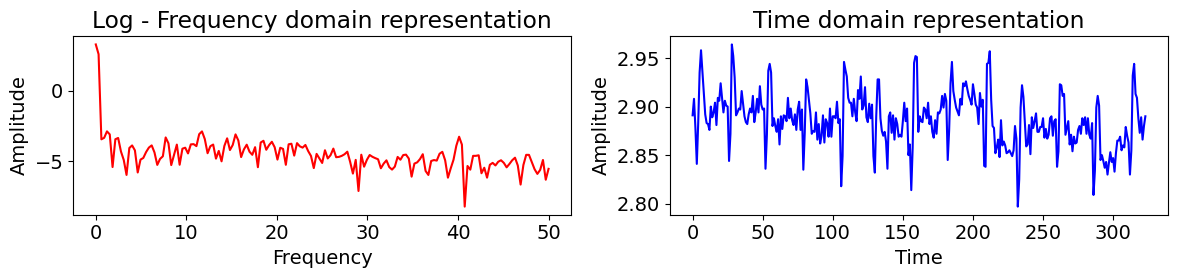

In [32]:
plt.rcParams.update({'font.size': 14})

sample = datahelper.extract_sample(rec, ana, wave_type = 'E1', which = 0)[1224:1548]

n_fft = len(sample)
stft_coefs = np.abs(librosa.stft(sample,n_fft = n_fft,center = False))/np.sqrt(n_fft)

freq_axis = librosa.fft_frequencies(sr = 100, n_fft = n_fft)
fig = plt.figure(figsize=(12,3))
ax1 = fig.add_subplot(121)
ax1.plot(freq_axis, np.log(stft_coefs[:,0]),color = 'r')
ax1.set_title(f"Log - Frequency domain representation")
ax1.set_xlabel('Frequency')
ax1.set_ylabel('Amplitude')
ax2 = fig.add_subplot(122)
ax2.plot(sample, color = 'blue')
ax2.set_title(f"Time domain representation")
ax2.set_xlabel('Time')
ax2.set_ylabel('Amplitude')
plt.tight_layout()
plt.show()

In [71]:
sliding_windows, labels = datagenerator.generate_sliding_windows(rec,ana, method = 'spectrogram', window_size= 1024, hop_length= 1024, scale = True, task = 'train')
labels = pd.Series(labels).map({1:'NP', 2:'C', 4:'E1', 5:'E2', 6:'F', 7:'G', 8:'pd'}).to_numpy()

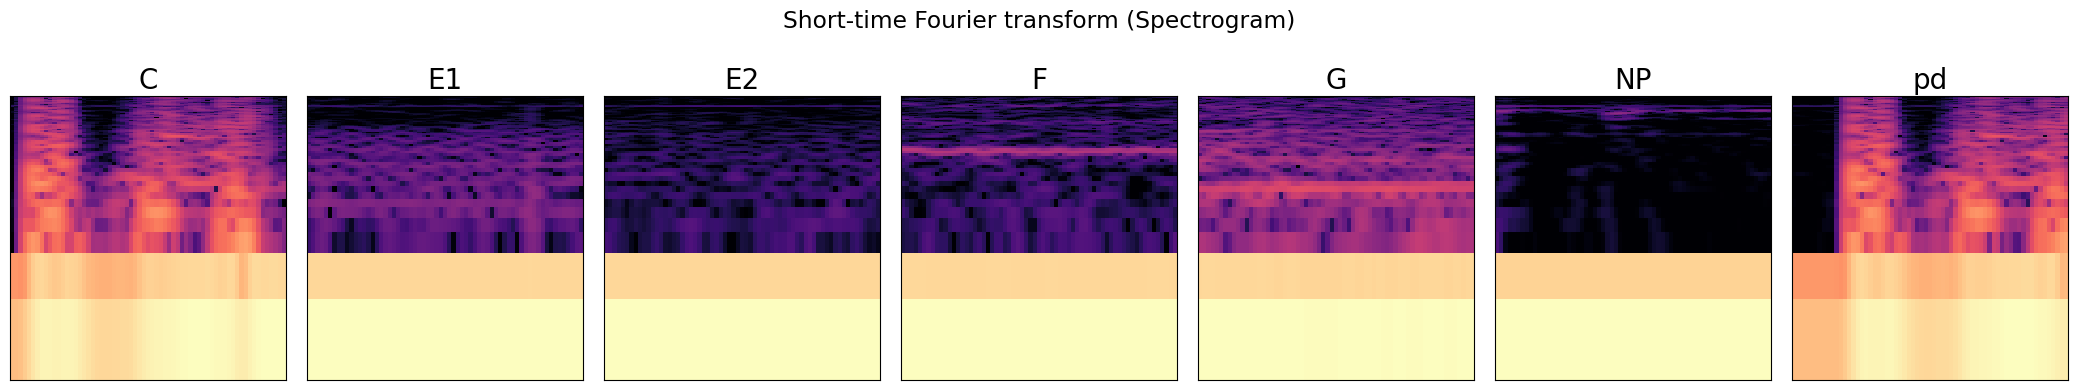

In [75]:
cl, c = np.unique(labels, return_counts=True)
f,ax = plt.subplots(1, 7, figsize = (21,4),sharey = True, sharex = True)
for i in range(7):
    sub_d = sliding_windows[labels == cl[i]]
    idx = np.random.randint(0,len(sub_d))
    img = sub_d[idx, :]
    img = (img - img.min())/(img.max() - img.min())
    librosa.display.specshow(img, y_axis = 'log', x_axis = 'time', ax = ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_title(cl[i], fontsize = 20)
    ax[i].tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
    # fig = plt.gcf()

plt.suptitle("Short-time Fourier transform (Spectrogram)")
plt.tight_layout()
plt.show()


## Wavelet transform

In [47]:
filename = '16zt_2022_10_04-ch5'
rec, ana = datahelper.read_signal(filename)
rec

array([-0.011     , -0.009     ,  0.047     , ...,  1.46300006,
        1.46899998,  1.47399998])

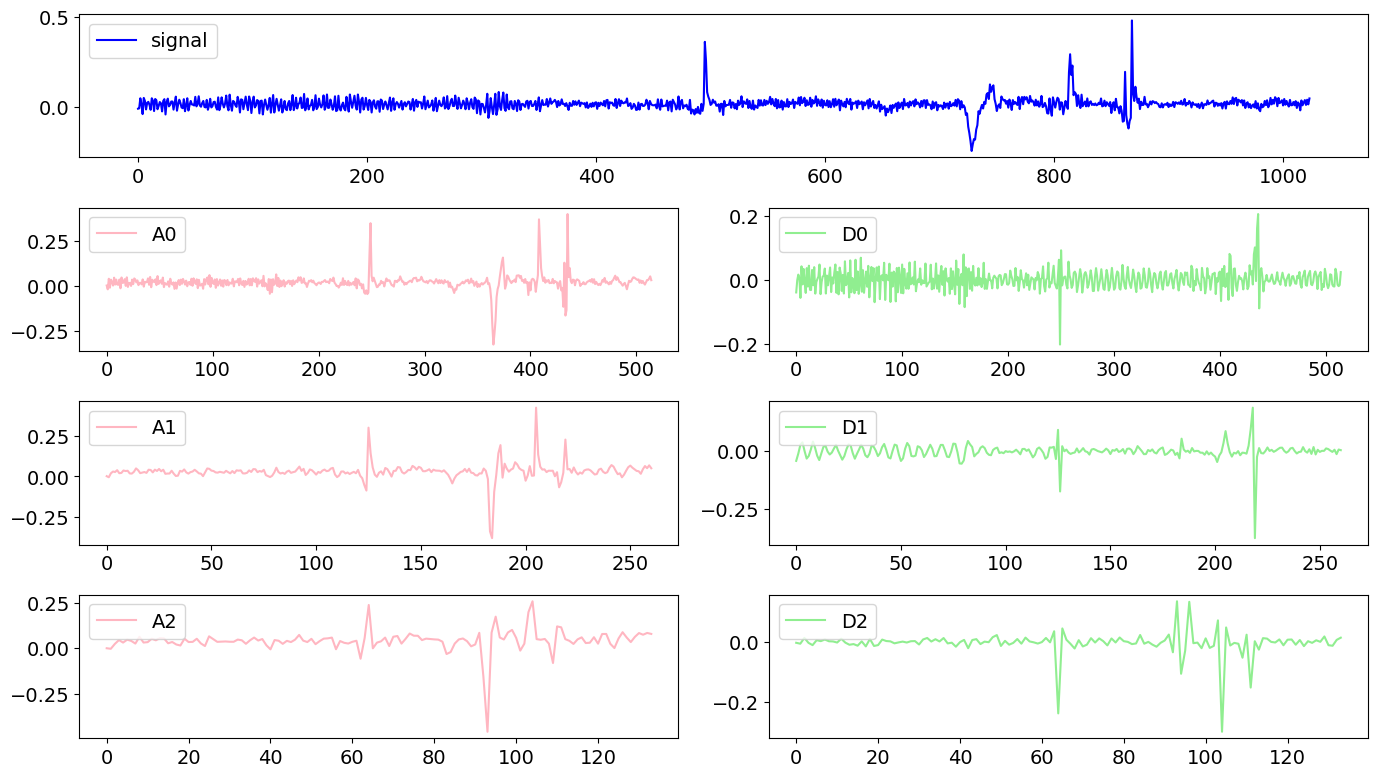

In [60]:
signal = datahelper.extract_sample(rec,ana,'NP',0)[0:1024]

A = []
D = []
cA = signal
for i in range(0,3):
    cA, cD = pywt.dwt(cA, wavelet = 'sym4')
    A.append(cA)
    D.append(cD)

fig = plt.figure(figsize=(14,8))
gs = fig.add_gridspec(4,2)
ax0 = fig.add_subplot(gs[0,:])
ax0.plot(signal, label = 'signal', color = 'blue')
ax0.legend(loc = 'upper left')
ax = []
for n in range(1,2*3+1):
    resolution = (n+1)//2
    small_ax = fig.add_subplot(gs[resolution, (n+1)%2])
    if (n+1)%2 == 0:
        small_ax.plot(A[resolution - 1], label = f'A{resolution - 1}', color = 'lightpink') 
    else: 
        small_ax.plot(D[resolution - 1], label = f'D{resolution - 1}', color = 'lightgreen') 
    small_ax.legend(loc = 'upper left')
    ax.append(small_ax)
plt.subplots_adjust(hspace=0.3)
plt.tight_layout()
plt.show()

In [77]:
sliding_windows, labels = datagenerator.generate_sliding_windows(rec,ana, method = 'raw', window_size= 1024, hop_length= 1024, scale = True, task = 'train')
labels = pd.Series(labels).map({1:'NP', 2:'C', 4:'E1', 5:'E2', 6:'F', 7:'G', 8:'pd'}).to_numpy()
cl, c = np.unique(labels, return_counts=True)
all_idx = [np.where(labels == cl[i])[0][0] for i in range(7)]
all_idx 

[19, 805, 811, 154, 596, 0, 32]

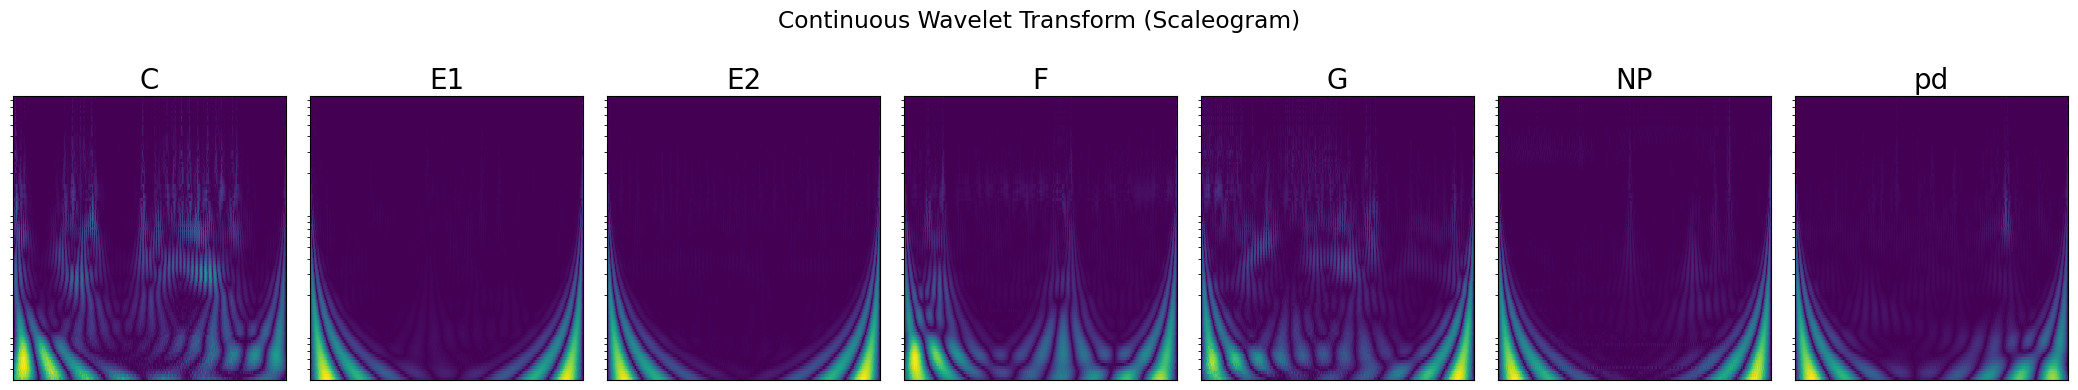

In [78]:
f,ax = plt.subplots(1, 7, figsize = (21,4), sharex = True)
for i in range(7):
    # generate signal
    time = np.linspace(0, 1, 1024)
    chirp = sliding_windows[all_idx[i],:]
    # perform CWT
    wavelet = "morl"
    # logarithmic scale for scales
    widths = np.geomspace(1, 200, num=100)
    sampling_period = np.diff(time).mean()
    cwtmatr, freqs = pywt.cwt(chirp, widths, wavelet, sampling_period=sampling_period)
    cwtmatr = np.abs(cwtmatr) # absolute take absolute value of complex result
    # cwtmatr = (cwtmatr - cwtmatr.min())/(cwtmatr.max() - cwtmatr.min()) # normalize
    # plot result using matplotlib's pcolormesh (image with annoted axes)
    pcm = ax[i].pcolormesh(time, freqs, cwtmatr)
    ax[i].set_yscale("log")
    ax[i].set_title(cl[i], fontsize = 20)
    ax[i].tick_params(left = False, right = False , labelleft = False , 
            labelbottom = False, bottom = False) 
plt.suptitle("Continuous Wavelet Transform (Scaleogram)")
plt.tight_layout()
plt.show()


## Gramian Angular Summation Field (GASF)

In [135]:
from pyts.image import GramianAngularField as GAF
gaf = GAF(image_size=64, method = 'summation', overlapping=True)
gaf_img = gaf.transform(window.reshape(1,-1))

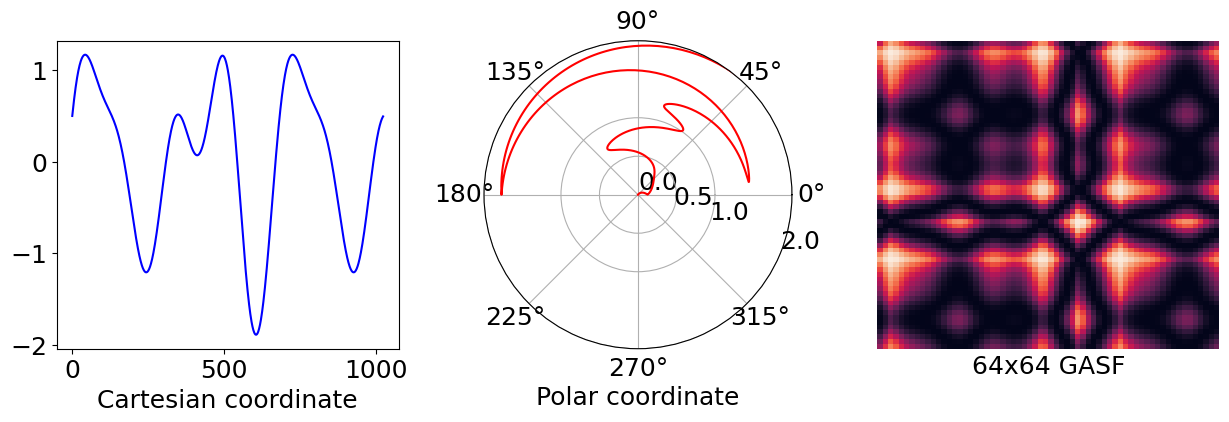

In [149]:
plt.rcParams.update({"font.size":18})
fig = plt.figure(figsize = (15,4))
ax1 = fig.add_subplot(131)
ax1.plot(window, c = 'b')
ax1.set_xlabel('Cartesian coordinate')
ax2 = fig.add_subplot(132, polar = True)
ax2.plot(phi, r, c = 'r')
ax2.set_rmax(2)
ax2.set_rticks([0,0.5,1,2])  # Less radial ticks
ax2.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax2.set_xlabel('Polar coordinate')
ax2.grid(True)
ax3 = fig.add_subplot(133)
sns.heatmap(gaf_img[0], ax=ax3, cbar = False, xticklabels=[], yticklabels=[])
# ax3.tick_params(left = False, right = False , labelleft = False , 
#                     labelbottom = False, bottom = False)
ax3.set_xlabel('64x64 GASF')
# plt.tight_layout()
plt.show()


In [ ]:
filename = '16zt_2022_10_04-ch5'
rec, ana = datahelper.read_signal(filename)
rec

array([-0.011     , -0.009     ,  0.047     , ...,  1.46300006,
        1.46899998,  1.47399998])

In [ ]:
sliding_windows, labels = datagenerator.generate_sliding_windows(rec,ana, method = 'gaf', window_size= 1024, hop_length= 1024, scale = True, task = 'train')
labels = pd.Series(labels).map({1:'NP', 2:'C', 4:'E1', 5:'E2', 6:'F', 7:'G', 8:'pd'}).to_numpy()
cl, c = np.unique(labels, return_counts=True)

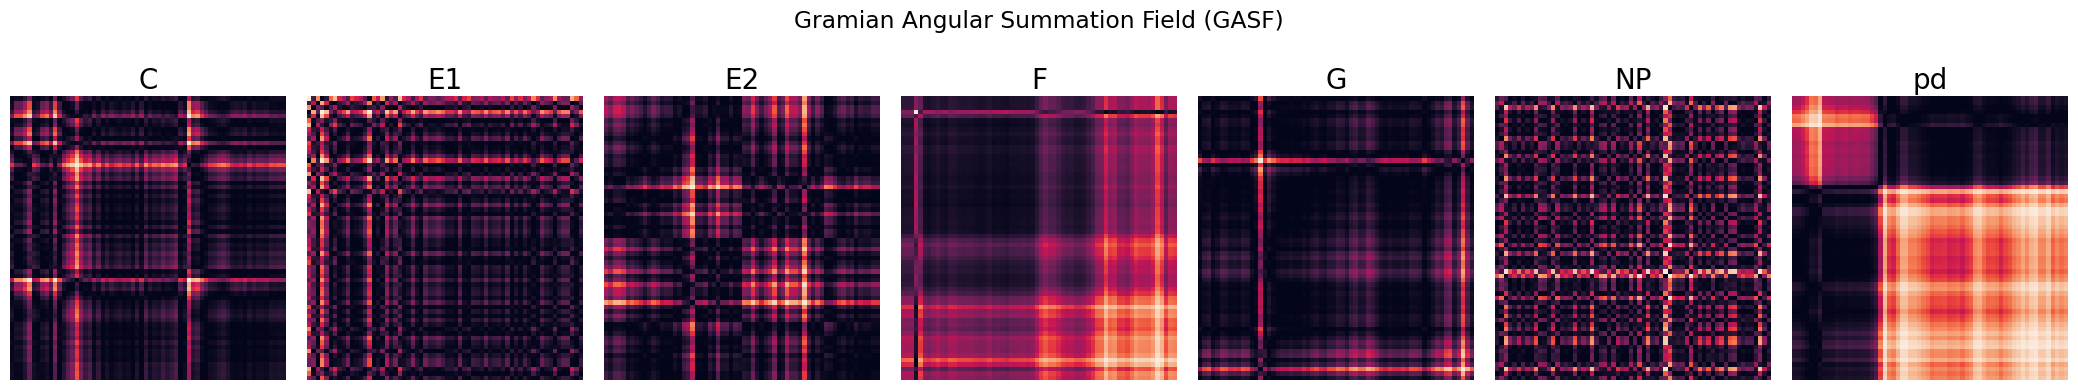

In [ ]:
f,ax = plt.subplots(1, 7, figsize = (21,4),sharey = True, sharex = True)
for i in range(7):
    sub_d = sliding_windows[labels == cl[i]]
    idx = np.random.randint(0,len(sub_d))
    img = sub_d[idx, :]
    img = (img - img.min())/(img.max() - img.min())
    sns.heatmap(img, cbar = False, ax = ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_title(cl[i], fontsize = 20)
    ax[i].tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
plt.suptitle("Gramian Angular Summation Field (GASF)")
plt.tight_layout()
plt.show()
